In [42]:
%%capture
#@title Instalamos gym
!pip install swig
!pip install "gymnasium[box2d]"
!pip install numpy
!pip install matplotlib
!pip install tqdm
#!pip install "gymnasium[toy-text]"
!pip install Box2D
!pip install pygame

In [43]:
#@title Importamos librerias
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
import Box2D

In [44]:
#@title Importamos el lago helado
name = 'Taxi-v3'

# Creamos el entorno Taxi-v3
env = gym.make(name, render_mode="ansi")


In [45]:
def q_learning(env, num_episodes=2000, learning_rate=0.1, epsilon_start=1.0, 
               epsilon_min=0.01, epsilon_decay=0.995, gamma=0.99):
    
    # Inicializamos Q-table con valores optimistas para fomentar la exploración
    Q = np.ones([env.observation_space.n, env.action_space.n]) * 10
    
    # Lista para almacenar recompensas
    rewards_per_episode = []
    episode_sizes = []
    epsilon = epsilon_start
    
    for episode in tqdm(range(num_episodes)):
        state, _ = env.reset()
        total_reward = 0
        steps = 0
        done = False
        
        while not done:
            # Epsilon-greedy con decaimiento
            if np.random.random() > epsilon:
                action = np.argmax(Q[state])
            else:
                action = env.action_space.sample()
            
            # Tomamos la acción
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Actualizamos Q-value usando Q-Learning (off-policy TD learning)
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + gamma * Q[next_state, best_next_action] * (not done)
            td_error = td_target - Q[state, action]
            Q[state, action] += learning_rate * td_error
            
            state = next_state
            total_reward += reward
            steps += 1
        
        # Decaimiento de epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        
        # Guardamos la recompensa total del episodio
        rewards_per_episode.append(total_reward)
        episode_sizes.append(steps)
        
        # Mostramos progreso cada 100 episodios
        if episode % 100 == 0:
            avg_reward = np.mean(rewards_per_episode[-100:])
            print(f"Episodio {episode}, Recompensa promedio: {avg_reward:.2f}, Epsilon: {epsilon:.2f}")
    
    return Q, rewards_per_episode, episode_sizes

In [46]:
def epsilon_greedy_policy(Q, state, epsilon, n_actions):
    if np.random.random() > epsilon:
        return np.argmax(Q[state])
    else:
        return env.action_space.sample()

In [47]:
def monte_carlo_on_policy(env, num_episodes=2000, epsilon_start=1.0, 
                          epsilon_min=0.01, epsilon_decay=0.995, gamma=0.99):
    # Inicializaciones
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    returns = dict()
    
    # Listas para almacenar estadísticas
    rewards_per_episode = []     # Recompensa total por episodio
    episode_sizes = []          # Número de pasos por episodio
    epsilon = epsilon_start
    
    def epsilon_greedy_policy(state):
        if np.random.random() > epsilon:
            return np.argmax(Q[state])
        else:
            return env.action_space.sample()
    
    for episode in tqdm(range(num_episodes)):
        # Variables para el episodio actual
        episode_states = []
        episode_actions = []
        episode_rewards = []
        steps_in_episode = 0
        
        # Iniciamos el episodio
        state, _ = env.reset()
        done = False
        
        # Ejecutamos el episodio
        while not done:
            action = epsilon_greedy_policy(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Guardamos la transición
            episode_states.append(state)
            episode_actions.append(action)
            episode_rewards.append(reward)
            
            state = next_state
            steps_in_episode += 1
        
        # Calculamos los retornos
        G = 0
        returns_episode = []
        for t in range(len(episode_rewards) - 1, -1, -1):
            G = gamma * G + episode_rewards[t]
            returns_episode.append(G)
        returns_episode.reverse()
        
        # Actualizamos Q-values (first-visit MC)
        states_actions_returns = list(zip(episode_states, episode_actions, returns_episode))
        for s, a, g in states_actions_returns:
            if (s, a) not in [(x[0], x[1]) for x in states_actions_returns[:states_actions_returns.index((s, a))]]:
                if (s, a) not in returns:
                    returns[(s, a)] = []
                returns[(s, a)].append(g)
                Q[s, a] = np.mean(returns[(s, a)])
        
        # Actualizamos epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        
        # Guardamos estadísticas
        total_reward = sum(episode_rewards)
        rewards_per_episode.append(total_reward)
        episode_sizes.append(steps_in_episode)
        
        # Mostramos progreso
        if episode % 100 == 0:
            avg_reward = np.mean(rewards_per_episode[-100:])
            avg_steps = np.mean(episode_sizes[-100:])
            print(f"Episodio {episode}")
            print(f"  Recompensa promedio: {avg_reward:.2f}")
            print(f"  Pasos promedio: {avg_steps:.2f}")
            print(f"  Epsilon: {epsilon:.2f}")
    
    return Q, rewards_per_episode, episode_sizes

In [48]:
def monte_carlo_off_policy(env, num_episodes=2000, gamma=0.99):
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    C = np.zeros([env.observation_space.n, env.action_space.n])  # Contador de pesos acumulados
    rewards_per_episode = []
    episode_sizes = []
    
    # Política target (greedy)
    def target_policy(state):
        return np.argmax(Q[state])
    
    # Política behavior (aleatoria)
    def behavior_policy(state):
        return env.action_space.sample()
    
    for episode in tqdm(range(num_episodes)):
        # Generamos episodio usando la política behavior
        episode_states = []
        episode_actions = []
        episode_rewards = []
        steps_in_episode = 0
        
        
        state, _ = env.reset()
        done = False
        
        while not done:
            action = behavior_policy(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            episode_states.append(state)
            episode_actions.append(action)
            episode_rewards.append(reward)
            
            state = next_state
            steps_in_episode += 1
        
        # Calculamos retornos y ratios de importancia
        G = 0
        W = 1  # Ratio de importancia inicial
        for t in range(len(episode_rewards) - 1, -1, -1):
            G = gamma * G + episode_rewards[t]
            state = episode_states[t]
            action = episode_actions[t]
            
            C[state, action] += W
            Q[state, action] += (W / C[state, action]) * (G - Q[state, action])
            
            # Si la acción tomada no coincide con la política target, rompemos
            if action != target_policy(state):
                break
                
            # Actualizamos el ratio de importancia
            W *= 1.0 / (1.0 / env.action_space.n)  # P(a|s)_target / P(a|s)_behavior
        
        rewards_per_episode.append(sum(episode_rewards))
        episode_sizes.append(steps_in_episode)
        
        if episode % 100 == 0:
            avg_reward = np.mean(rewards_per_episode[-100:])
            print(f"Episodio {episode}, Recompensa promedio: {avg_reward:.2f}")
    
    return Q, rewards_per_episode, episode_sizes

In [49]:
def sarsa(env, num_episodes=2000, learning_rate=0.1, epsilon_start=1.0, 
          epsilon_min=0.01, epsilon_decay=0.995, gamma=0.99):
    
    # Inicializamos Q-table
    Q = np.ones([env.observation_space.n, env.action_space.n]) * 10
    rewards_per_episode = []
    episodes_sizes = []
    epsilon = epsilon_start
    
    for episode in tqdm(range(num_episodes)):
        state, _ = env.reset()
        # Seleccionamos la primera acción usando epsilon-greedy
        action = epsilon_greedy_policy(Q, state, epsilon, env.action_space.n)
        total_reward = 0
        steps = 0
        done = False
        
        while not done:
            # Tomamos la acción y observamos el resultado
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            if not done:
                # Seleccionamos la siguiente acción usando la misma política
                next_action = epsilon_greedy_policy(Q, next_state, epsilon, env.action_space.n)
                # Actualización SARSA
                Q[state, action] += learning_rate * (
                    reward + gamma * Q[next_state, next_action] - Q[state, action]
                )
                # Preparamos para el siguiente paso
                state = next_state
                action = next_action
            else:
                # Actualización final del episodio
                Q[state, action] += learning_rate * (reward - Q[state, action])
            
            total_reward += reward
            steps += 1
        
        # Decaimiento de epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_per_episode.append(total_reward)
        episodes_sizes.append(steps)
        
        if episode % 100 == 0:
            avg_reward = np.mean(rewards_per_episode[-100:])
            print(f"Episodio {episode}, Recompensa promedio: {avg_reward:.2f}, Epsilon: {epsilon:.2f}")
    
    return Q, rewards_per_episode, episodes_sizes

In [50]:
def plot_training_results(rewards):
    # Calculamos la media móvil para suavizar la gráfica
    window_size = 50
    moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    
    plt.figure(figsize=(10, 5))
    plt.plot(moving_avg, label='Recompensa promedio (media móvil)')
    plt.plot(rewards, alpha=0.2, label='Recompensa por episodio')
    plt.title('Entrenamiento del agente en Taxi-v3')
    plt.xlabel('Episodio')
    plt.ylabel('Recompensa total')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_learning_analysis(list_stats, episode_sizes):
    # Creamos una figura con 3 subplots
    plt.figure(figsize=(12, 9))
    
    # 1. Proporción de recompensas
    plt.subplot(3, 1, 1)
    indices = list(range(len(list_stats)))
    plt.plot(indices, list_stats)
    plt.title('Proporción de recompensas')
    plt.xlabel('Episodio')
    plt.ylabel('Proporción')
    plt.grid(True)
    
    # 2. Tamaño de los episodios
    plt.subplot(3, 1, 2)
    indices = list(range(len(episode_sizes)))
    plt.plot(indices, episode_sizes)
    window_size = 50
    moving_avg = np.convolve(episode_sizes, np.ones(window_size)/window_size, mode='valid')
    plt.plot(indices[window_size-1:], moving_avg, 'r', alpha=0.5, label='Media móvil')
    plt.title('Tamaño de los episodios')
    plt.xlabel('Episodio')
    plt.ylabel('Número de pasos')
    plt.grid(True)
    plt.legend()
    
    # 3. Longitud del episodio en función del tiempo f(t) = len(episodiot)
    plt.subplot(3, 1, 3)
    cumulative_steps = np.cumsum(episode_sizes)
    plt.plot(cumulative_steps, episode_sizes, label='Longitud del episodio')
    # Media móvil para ver la tendencia
    window_size = 50
    moving_avg = np.convolve(episode_sizes, np.ones(window_size)/window_size, mode='valid')
    plt.plot(cumulative_steps[window_size-1:], moving_avg, 'r', alpha=0.5, label='Media móvil')
    plt.title('Longitud del episodio vs Tiempo total')
    plt.xlabel('Tiempo total (pasos acumulados)')
    plt.ylabel('Longitud del episodio')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [51]:
'''Q, rewards, episodes = monte_carlo_on_policy(
    env,
    num_episodes=2000,
    epsilon_start=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.995,
    gamma=0.99
)'''

#Q, rewards, episodes = monte_carlo_off_policy(env, num_episodes=2000, gamma=0.99)

Q, rewards, episodes = q_learning(
    env,
    num_episodes=2000,
    learning_rate=0.1,
    epsilon_start=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.995,
    gamma=0.99
)

'''# Entrenamos el agente usando SARSA
Q, rewards, episodes = sarsa(
    env,
    num_episodes=2000,
    learning_rate=0.1,
    epsilon_start=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.995,
    gamma=0.99
)'''

  0%|          | 0/2000 [00:00<?, ?it/s]

  4%|▎         | 73/2000 [00:00<00:05, 360.75it/s]

Episodio 0, Recompensa promedio: -704.00, Epsilon: 0.99


  8%|▊         | 162/2000 [00:00<00:04, 415.16it/s]

Episodio 100, Recompensa promedio: -647.89, Epsilon: 0.60


 13%|█▎        | 257/2000 [00:00<00:03, 447.72it/s]

Episodio 200, Recompensa promedio: -414.23, Epsilon: 0.37
Episodio 300, Recompensa promedio: -258.37, Epsilon: 0.22


 28%|██▊       | 557/2000 [00:01<00:01, 728.53it/s]

Episodio 400, Recompensa promedio: -166.53, Epsilon: 0.13
Episodio 500, Recompensa promedio: -105.07, Epsilon: 0.08
Episodio 600, Recompensa promedio: -62.36, Epsilon: 0.05


 59%|█████▉    | 1181/2000 [00:01<00:00, 1747.36it/s]

Episodio 700, Recompensa promedio: -43.98, Epsilon: 0.03
Episodio 800, Recompensa promedio: -28.08, Epsilon: 0.02
Episodio 900, Recompensa promedio: -17.24, Epsilon: 0.01
Episodio 1000, Recompensa promedio: -8.08, Epsilon: 0.01
Episodio 1100, Recompensa promedio: -6.46, Epsilon: 0.01


100%|██████████| 2000/2000 [00:01<00:00, 1345.67it/s]

Episodio 1200, Recompensa promedio: -3.07, Epsilon: 0.01
Episodio 1300, Recompensa promedio: 1.13, Epsilon: 0.01
Episodio 1400, Recompensa promedio: 0.33, Epsilon: 0.01
Episodio 1500, Recompensa promedio: 2.27, Epsilon: 0.01
Episodio 1600, Recompensa promedio: 4.94, Epsilon: 0.01
Episodio 1700, Recompensa promedio: 5.79, Epsilon: 0.01
Episodio 1800, Recompensa promedio: 5.41, Epsilon: 0.01
Episodio 1900, Recompensa promedio: 6.31, Epsilon: 0.01


'# Entrenamos el agente usando SARSA\nQ, rewards, episodes = sarsa(\n    env,\n    num_episodes=2000,\n    learning_rate=0.1,\n    epsilon_start=1.0,\n    epsilon_min=0.01,\n    epsilon_decay=0.995,\n    gamma=0.99\n)'

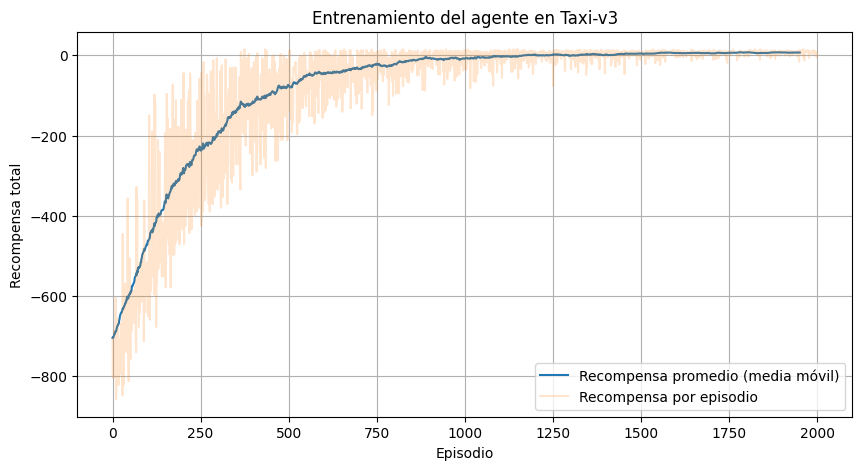

In [52]:
# Visualizamos los resultados
plot_training_results(rewards)

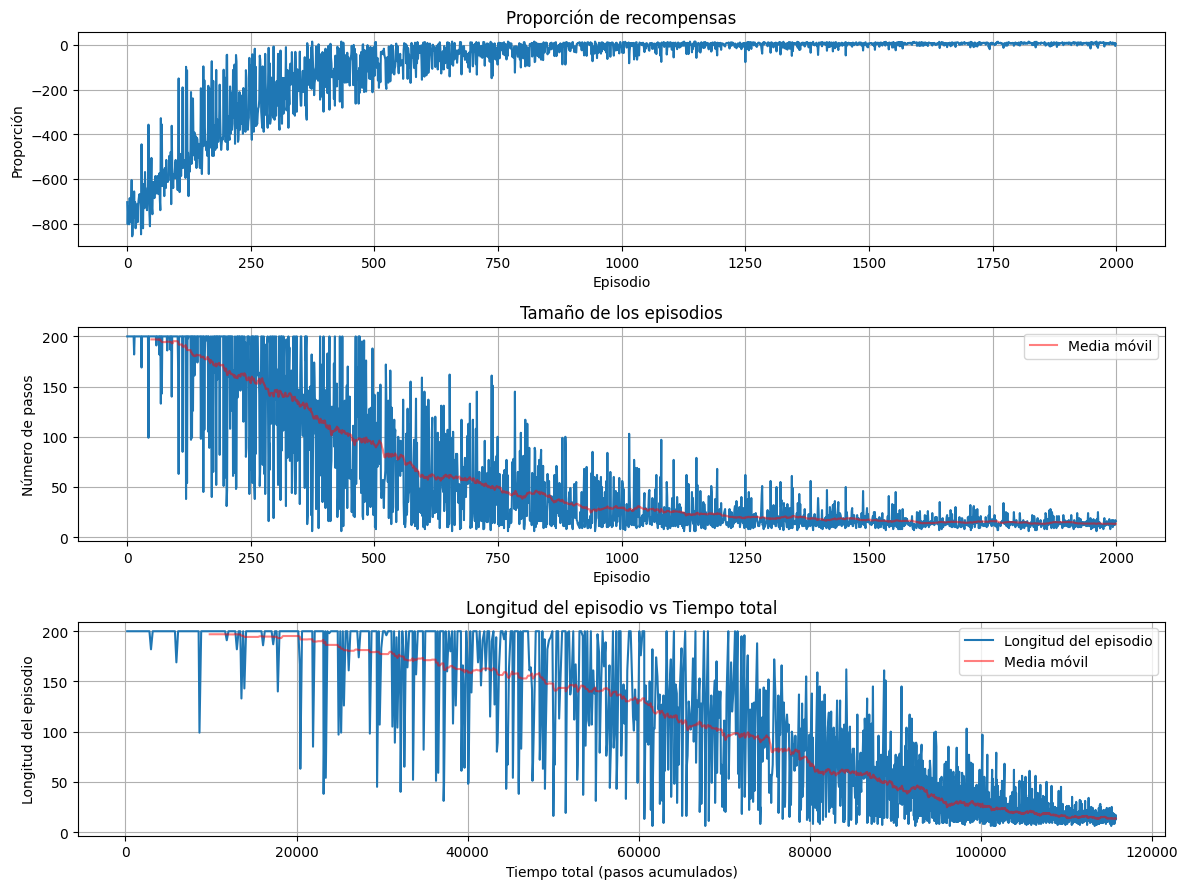

In [53]:
plot_learning_analysis(rewards, episodes)

In [54]:
# Función para evaluar el rendimiento
def evaluate_agent(env, Q, n_episodes=100):
    total_rewards = []
    for _ in range(n_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        while not done:
            action = np.argmax(Q[state])
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
        total_rewards.append(episode_reward)
    return np.mean(total_rewards)

In [55]:
# Evaluamos el agente
mean_reward = evaluate_agent(env, Q)
print(f"\nRecompensa promedio en evaluación: {mean_reward}")


Recompensa promedio en evaluación: -68.47


In [56]:
# Política Greedy a partir de los valones Q. Se usa para mostrar la solución.
def pi_star_from_Q(env, Q):
    done = False
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    state, info = env.reset() # start in top-left, = 0
    actions = ""
    while not done:
        action = np.argmax(Q[state, :])
        actions += f"{action}, "
        pi_star[state,action] = action
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    return pi_star, actions

In [57]:
# @title Política final
LEFT, DOWN, RIGHT, UP = 0,1,2,3
pi, actions = pi_star_from_Q(env, Q)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env.render())
print()

Política óptima obtenida
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 4. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]] 
 Acciones 3, 3, 3, 1, 3, 1, 4, 0, 0, 0, 0, 5,  
 Para el siguiente grid
 +---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


